# EKF Derivations

In [3]:
import symforce
symforce.set_symbolic_api("sympy")
symforce.set_log_level("warning")
import symforce.symbolic as sf
from symforce import ops
from symforce.notebook_util import display

In [6]:
# Accelerometer and gyroscope reading
gyro = sf.Vector3.symbolic('\omega')
accel = sf.Vector3.symbolic('a')
# Accelerometer and gyroscope bias
b_a = sf.Vector3.symbolic('b_a')
b_g = sf.Vector3.symbolic('b_g')
# Gravity in world frame
gravity = sf.Vector3([0, 0, -9.8])
# Foot positions in world frame
s1 = sf.Vector3.symbolic('s_{FR}')
s2 = sf.Vector3.symbolic('s_{FL}')
s3 = sf.Vector3.symbolic('s_{RR}')
s4 = sf.Vector3.symbolic('s_{RL}')
# Integration time interval
dT = sf.Symbol('\Delta t')
# Body orientation, position, and velocity 
q = sf.Quaternion.symbolic('q')
p = sf.Vector3.symbolic('p')
v = sf.Vector3.symbolic('v')

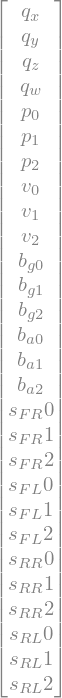

In [7]:
state = sf.Matrix.block_matrix([[sf.Matrix([q.x, q.y, q.z, q.w])],\
                                [p],\
                                [v],\
                                [b_g],\
                                [b_a],\
                                [s1],\
                                [s2],\
                                [s3],\
                                [s4]])
state

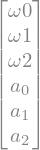

In [8]:
u = sf.Matrix.block_matrix([[gyro], [accel]])
u

In [12]:
# Process Model
f1 = q*sf.Quaternion(xyz=0.5*(gyro-b_g)*dT, w = 1)
# f1 = q*sf.Rot3.from_tangent((gyro-b_g)*dT, epsilon=epsilon).q
f1 = sf.Matrix([f1.x, f1.y, f1.z, f1.w])
f2 = p+dT*v
f3 = v+sf.Rot3(q).to_rotation_matrix()*(accel-b_a)-gravity
f4 = b_g
f5 = b_a
f6 = s1
f7 = s2
f8 = s3
f9 = s4

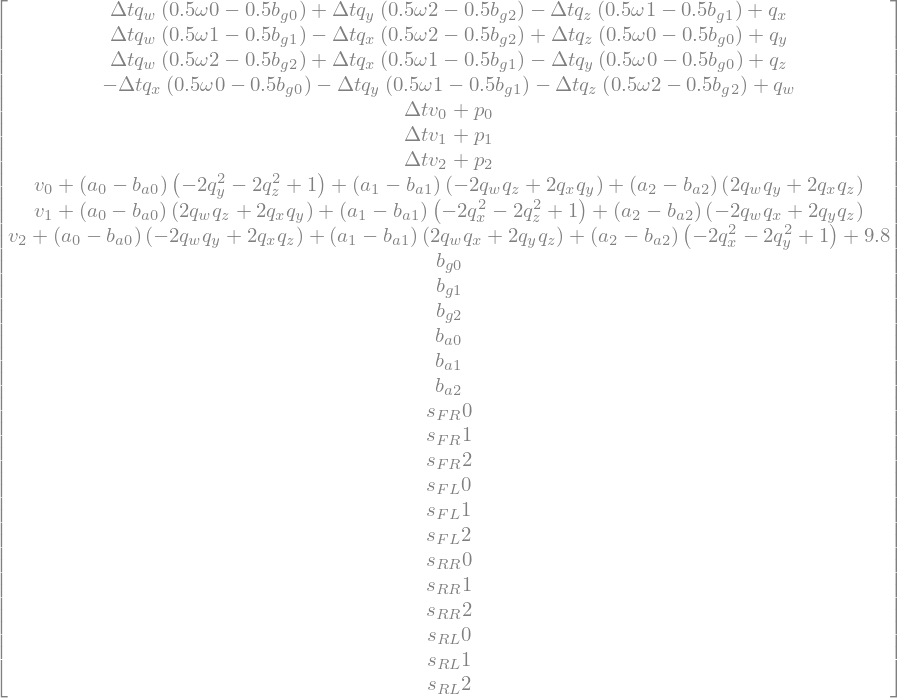

In [13]:
f = sf.Matrix.block_matrix([[f1],\
                            [f2],\
                            [f3],\
                            [f4],\
                            [f5],\
                            [f6],\
                            [f7],\
                            [f8],\
                            [f9]])
f

In [7]:
A_x = f.jacobian(state)
A_x 

⎡                          1                                            \Delta
⎢                                                                             
⎢              -\Delta t⋅(\omega2 - b_g2)                                     
⎢                                                                             
⎢              \Delta t⋅(\omega1 - b_g1)                               -\Delta
⎢                                                                             
⎢              -\Delta t⋅(\omega0 - b_g0)                              -\Delta
⎢                                                                             
⎢                          0                                                  
⎢                                                                             
⎢                          0                                                  
⎢                                                                             
⎢                          0                        

In [8]:
A_u = f.jacobian(u)
A_u

⎡\Delta t⋅q_w   -\Delta t⋅q_z  \Delta t⋅q_y             0                     
⎢                                                                             
⎢\Delta t⋅q_z   \Delta t⋅q_w   -\Delta t⋅qₓ             0                     
⎢                                                                             
⎢-\Delta t⋅q_y   \Delta t⋅qₓ   \Delta t⋅q_w             0                     
⎢                                                                             
⎢-\Delta t⋅qₓ   -\Delta t⋅q_y  -\Delta t⋅q_z            0                     
⎢                                                                             
⎢      0              0              0                  0                     
⎢                                                                             
⎢      0              0              0                  0                     
⎢                                                                             
⎢      0              0              0              

In [9]:
#Measurement model
R = sf.Rot3(q).to_rotation_matrix()
z1 = R.T*v
z2 = R.T*(s1-p)
z3 = R.T*(s2-p)
z4 = R.T*(s3-p)
z5 = R.T*(s4-p)
h = sf.Matrix.block_matrix([[z1],
                            [z2],
                            [z3],
                            [z4],
                            [z5]])
h

⎡                      ⎛       2        2    ⎞                                
⎢                   v₀⋅⎝- 2⋅q_y  - 2⋅q_z  + 1⎠ + v₁⋅(2⋅q_w⋅q_z + 2⋅qₓ⋅q_y) + v
⎢                                                                             
⎢                                                    ⎛      2        2    ⎞   
⎢                    v₀⋅(-2⋅q_w⋅q_z + 2⋅qₓ⋅q_y) + v₁⋅⎝- 2⋅qₓ  - 2⋅q_z  + 1⎠ + 
⎢                                                                             
⎢                                                                             
⎢                    v₀⋅(2⋅q_w⋅q_y + 2⋅qₓ⋅q_z) + v₁⋅(-2⋅q_w⋅qₓ + 2⋅q_y⋅q_z) + 
⎢                                                                             
⎢                ⎛       2        2    ⎞                                      
⎢(-p₀ + s_{FR}0)⋅⎝- 2⋅q_y  - 2⋅q_z  + 1⎠ + (-p₁ + s_{FR}1)⋅(2⋅q_w⋅q_z + 2⋅qₓ⋅q
⎢                                                                             
⎢                                                   

In [10]:
H = h.jacobian(state)
H

⎡                                                                             
⎢                         2⋅q_y⋅v₁ + 2⋅q_z⋅v₂                                 
⎢                                                                             
⎢                                                                             
⎢                    2⋅q_w⋅v₂ - 4⋅qₓ⋅v₁ + 2⋅q_y⋅v₀                            
⎢                                                                             
⎢                                                                             
⎢                   -2⋅q_w⋅v₁ - 4⋅qₓ⋅v₂ + 2⋅q_z⋅v₀                            
⎢                                                                             
⎢                                                                             
⎢            2⋅q_y⋅(-p₁ + s_{FR}1) + 2⋅q_z⋅(-p₂ + s_{FR}2)              -2⋅q_w
⎢                                                                             
⎢                                                   

In [11]:
R_vel = sf.Symbol('R_v')
R_s1 = sf.Symbol('R_{s_{FR}}')
R_s2 = sf.Symbol('R_{s_{FL}}')
R_s3 = sf.Symbol('R_{s_{RR}}')
R_s4 = sf.Symbol('R_{s_{RL}}')

R_cov    = sf.Matrix.diag([R_vel,R_vel,R_vel,
                           R_s1, R_s1, R_s1,
                           R_s2, R_s2, R_s2,
                           R_s3, R_s3, R_s3,
                           R_s4, R_s4, R_s4])
R_cov

⎡Rᵥ  0   0       0           0           0           0           0           0
⎢                                                                             
⎢0   Rᵥ  0       0           0           0           0           0           0
⎢                                                                             
⎢0   0   Rᵥ      0           0           0           0           0           0
⎢                                                                             
⎢0   0   0   R_{s_{FR}}      0           0           0           0           0
⎢                                                                             
⎢0   0   0       0       R_{s_{FR}}      0           0           0           0
⎢                                                                             
⎢0   0   0       0           0       R_{s_{FR}}      0           0           0
⎢                                                                             
⎢0   0   0       0           0           0       R_{

In [12]:

Q_vel = sf.Symbol('Q_v')
Q_pos = sf.Symbol('Q_p')
Q_quat = sf.Symbol('Q_q')
Q_bg = sf.Symbol('Q_bg')
Q_ba = sf.Symbol('Q_ba')
Q_s1 = sf.Symbol('Q_{s_{FR}}')
Q_s2 = sf.Symbol('Q_{s_{FL}}')
Q_s3 = sf.Symbol('Q_{s_{RR}}')
Q_s4 = sf.Symbol('Q_{s_{RL}}')

Q_cov    = sf.Matrix.diag([Q_quat,Q_quat,Q_quat,Q_quat,
                           Q_pos, Q_pos, Q_pos,
                           Q_vel, Q_vel, Q_vel,
                           Q_bg, Q_bg, Q_bg,
                           Q_ba, Q_ba, Q_ba,
                           Q_s1, Q_s1, Q_s1,
                           Q_s2, Q_s2, Q_s2,
                           Q_s3, Q_s3, Q_s3,
                           Q_s4, Q_s4, Q_s4])
Q_cov


⎡Q_q   0    0    0   0   0   0   0   0   0    0     0     0     0     0     0 
⎢                                                                             
⎢ 0   Q_q   0    0   0   0   0   0   0   0    0     0     0     0     0     0 
⎢                                                                             
⎢ 0    0   Q_q   0   0   0   0   0   0   0    0     0     0     0     0     0 
⎢                                                                             
⎢ 0    0    0   Q_q  0   0   0   0   0   0    0     0     0     0     0     0 
⎢                                                                             
⎢ 0    0    0    0   Qₚ  0   0   0   0   0    0     0     0     0     0     0 
⎢                                                                             
⎢ 0    0    0    0   0   Qₚ  0   0   0   0    0     0     0     0     0     0 
⎢                                                                             
⎢ 0    0    0    0   0   0   Qₚ  0   0   0    0     

In [13]:
state

⎡  qₓ   ⎤
⎢       ⎥
⎢  q_y  ⎥
⎢       ⎥
⎢  q_z  ⎥
⎢       ⎥
⎢  q_w  ⎥
⎢       ⎥
⎢  p₀   ⎥
⎢       ⎥
⎢  p₁   ⎥
⎢       ⎥
⎢  p₂   ⎥
⎢       ⎥
⎢  v₀   ⎥
⎢       ⎥
⎢  v₁   ⎥
⎢       ⎥
⎢  v₂   ⎥
⎢       ⎥
⎢ b_g0  ⎥
⎢       ⎥
⎢ b_g1  ⎥
⎢       ⎥
⎢ b_g2  ⎥
⎢       ⎥
⎢  bₐ₀  ⎥
⎢       ⎥
⎢  bₐ₁  ⎥
⎢       ⎥
⎢  bₐ₂  ⎥
⎢       ⎥
⎢s_{FR}0⎥
⎢       ⎥
⎢s_{FR}1⎥
⎢       ⎥
⎢s_{FR}2⎥
⎢       ⎥
⎢s_{FL}0⎥
⎢       ⎥
⎢s_{FL}1⎥
⎢       ⎥
⎢s_{FL}2⎥
⎢       ⎥
⎢s_{RR}0⎥
⎢       ⎥
⎢s_{RR}1⎥
⎢       ⎥
⎢s_{RR}2⎥
⎢       ⎥
⎢s_{RL}0⎥
⎢       ⎥
⎢s_{RL}1⎥
⎢       ⎥
⎣s_{RL}2⎦

In [14]:
P = sf.matrix_type_from_shape((28,28)).symbolic('P')

In [15]:
state = sf.Matrix.block_matrix([[sf.Matrix([q.x, q.y, q.z, q.w])],\
                                [p],\
                                [v],\
                                [b_g],\
                                [b_a],\
                                [s1],\
                                [s2],\
                                [s3],\
                                [s4]])
state

⎡  qₓ   ⎤
⎢       ⎥
⎢  q_y  ⎥
⎢       ⎥
⎢  q_z  ⎥
⎢       ⎥
⎢  q_w  ⎥
⎢       ⎥
⎢  p₀   ⎥
⎢       ⎥
⎢  p₁   ⎥
⎢       ⎥
⎢  p₂   ⎥
⎢       ⎥
⎢  v₀   ⎥
⎢       ⎥
⎢  v₁   ⎥
⎢       ⎥
⎢  v₂   ⎥
⎢       ⎥
⎢ b_g0  ⎥
⎢       ⎥
⎢ b_g1  ⎥
⎢       ⎥
⎢ b_g2  ⎥
⎢       ⎥
⎢  bₐ₀  ⎥
⎢       ⎥
⎢  bₐ₁  ⎥
⎢       ⎥
⎢  bₐ₂  ⎥
⎢       ⎥
⎢s_{FR}0⎥
⎢       ⎥
⎢s_{FR}1⎥
⎢       ⎥
⎢s_{FR}2⎥
⎢       ⎥
⎢s_{FL}0⎥
⎢       ⎥
⎢s_{FL}1⎥
⎢       ⎥
⎢s_{FL}2⎥
⎢       ⎥
⎢s_{RR}0⎥
⎢       ⎥
⎢s_{RR}1⎥
⎢       ⎥
⎢s_{RR}2⎥
⎢       ⎥
⎢s_{RL}0⎥
⎢       ⎥
⎢s_{RL}1⎥
⎢       ⎥
⎣s_{RL}2⎦

## Generate Codes

In [16]:
def compute_mean( state: sf.matrix_type_from_shape((28,1)), u: sf.matrix_type_from_shape((6,1)), dT: sf.Scalar = 0, epsilon: sf.Scalar = 0) -> sf.matrix_type_from_shape((28,1)):
    omega = u[0:3]
    accel = u[3:6]
    q = sf.Quaternion(xyz=state[0:3], w=state[3])
    p = state[4:7]
    v = state[7:10]
    b_g = state[10:13]
    b_a = state[13:16]
    s1 = state[16:19]
    s2 = state[19:22]
    s3 = state[22:25]
    s4 = state[25:28]
    f1 = q*sf.Quaternion(xyz=(omega-b_g)*dT, w = 1.)
    # f1 = q*sf.Rot3.from_tangent((gyro-b_g)*dT, epsilon=epsilon).q
    f1 = sf.Matrix([f1.x, f1.y, f1.z, f1.w])
    f2 = p+dT*v
    f3 = v+sf.Rot3(q).to_rotation_matrix()*(accel-b_a)-gravity
    f4 = b_g
    f5 = b_a
    f6 = s1
    f7 = s2
    f8 = s3
    f9 = s4
    f = sf.Matrix.block_matrix([[f1],\
                            [f2],\
                            [f3],\
                            [f4],\
                            [f5],\
                            [f6],\
                            [f7],\
                            [f8],\
                            [f9]])
    return f

In [17]:
f_pred = compute_mean(state, u, dT)
f_pred

⎡       \Delta t⋅q_w⋅(\omega0 - b_g0) + \Delta t⋅q_y⋅(\omega2 - b_g2) - \Delta
⎢                                                                             
⎢       \Delta t⋅q_w⋅(\omega1 - b_g1) - \Delta t⋅qₓ⋅(\omega2 - b_g2) + \Delta 
⎢                                                                             
⎢       \Delta t⋅q_w⋅(\omega2 - b_g2) + \Delta t⋅qₓ⋅(\omega1 - b_g1) - \Delta 
⎢                                                                             
⎢       -\Delta t⋅qₓ⋅(\omega0 - b_g0) - \Delta t⋅q_y⋅(\omega1 - b_g1) - \Delta
⎢                                                                             
⎢                                                  \Delta t⋅v₀ + p₀           
⎢                                                                             
⎢                                                  \Delta t⋅v₁ + p₁           
⎢                                                                             
⎢                                                  \

In [18]:
def compute_measurement( state: sf.matrix_type_from_shape((28,1)), epsilon: sf.Scalar = 0)\
 -> sf.matrix_type_from_shape((15,1)):
    q = sf.Quaternion(xyz=state[0:3], w=state[3])
    p = state[4:7]
    v = state[7:10]
    b_g = state[10:13]
    b_a = state[13:16]
    s1 = state[16:19]
    s2 = state[19:22]
    s3 = state[22:25]
    s4 = state[25:28]
    R = sf.Rot3(q).to_rotation_matrix()
    z1 = R.T*v
    z2 = R.T*(s1-p)
    z3 = R.T*(s2-p)
    z4 = R.T*(s3-p)
    z5 = R.T*(s4-p)
    h = sf.Matrix.block_matrix([[z1],
                                [z2],
                                [z3],
                                [z4],
                                [z5]])
    return h

In [19]:
compute_measurement(state)

⎡                      ⎛       2        2    ⎞                                
⎢                   v₀⋅⎝- 2⋅q_y  - 2⋅q_z  + 1⎠ + v₁⋅(2⋅q_w⋅q_z + 2⋅qₓ⋅q_y) + v
⎢                                                                             
⎢                                                    ⎛      2        2    ⎞   
⎢                    v₀⋅(-2⋅q_w⋅q_z + 2⋅qₓ⋅q_y) + v₁⋅⎝- 2⋅qₓ  - 2⋅q_z  + 1⎠ + 
⎢                                                                             
⎢                                                                             
⎢                    v₀⋅(2⋅q_w⋅q_y + 2⋅qₓ⋅q_z) + v₁⋅(-2⋅q_w⋅qₓ + 2⋅q_y⋅q_z) + 
⎢                                                                             
⎢                ⎛       2        2    ⎞                                      
⎢(-p₀ + s_{FR}0)⋅⎝- 2⋅q_y  - 2⋅q_z  + 1⎠ + (-p₁ + s_{FR}1)⋅(2⋅q_w⋅q_z + 2⋅qₓ⋅q
⎢                                                                             
⎢                                                   

In [20]:
from symforce import codegen
from symforce.codegen import codegen_util
from symforce.notebook_util import display
from symforce.notebook_util import display_code_file
from symforce.values import Values

In [21]:
compute_measurement_codegen = codegen.Codegen.function(
    func=compute_measurement,
    config=codegen.CppConfig(),
)

codegen_with_jacobians = compute_measurement_codegen.with_jacobians(
    # Just compute wrt the pose and point, not epsilon
    which_args=["state"],
    # Include value, not just jacobians
    include_results=True,
)

data = codegen_with_jacobians.generate_function()

display_code_file(data.generated_files[0], "C++")


codegen.__init__():141 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code, you should set epsilon to either a symbol
    (recommended) or a small numerical value like `sf.numeric_epsilon`.  You should do
    this before importing any other code from symforce, e.g. with

        import symforce
        symforce.set_epsilon_to_symbol()

    or

        import symforce
        symforce.set_epsilon_to_number()

    For more information on use of epsilon to prevent singularities, take a look at the
    Epsilon Tutorial: https://symforce.org/tutorials/epsilon_tutorial.html

codegen.__init__():141 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code

In [22]:
compute_mean_codegen = codegen.Codegen.function(
    func=compute_mean,
    config=codegen.CppConfig(),
)

codegen_with_jacobians = compute_mean_codegen.with_jacobians(
    # Just compute wrt the pose and point, not epsilon
    which_args=["state"],
    # Include value, not just jacobians
    include_results=True,
)

data = codegen_with_jacobians.generate_function()

display_code_file(data.generated_files[0], "C++")


codegen.__init__():141 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code, you should set epsilon to either a symbol
    (recommended) or a small numerical value like `sf.numeric_epsilon`.  You should do
    this before importing any other code from symforce, e.g. with

        import symforce
        symforce.set_epsilon_to_symbol()

    or

        import symforce
        symforce.set_epsilon_to_number()

    For more information on use of epsilon to prevent singularities, take a look at the
    Epsilon Tutorial: https://symforce.org/tutorials/epsilon_tutorial.html

codegen.__init__():141 WARNING -- 
    Generating code with epsilon set to 0 - This is dangerous!  You may get NaNs, Infs,
    or numerically unstable results from calling generated functions near singularities.

    In order to safely generate code